# NYC Socrata Portal Analyis

This notebook examines some meta-statistics on the datasets on the NYC Socrata portal. It uses a handful of functions from the `socrata-reducer` library, written for this purpose.

## Part I: Definitions

### Socrata

**Socrata** is a late-stage privately held startup (which may go to IPO any day now) which maintains the Socrata Portal, an interface for hosting open data on the web. The [New York City Open Data Portal](https://nycopendata.socrata.com/) runs off of a Socrata instance, as do many others; in fact I would go so far as to say that Socrata has a dominent lead in both market and mind share amongst open data practitioners and offices in the United States (for a survey of all of them, check out http://opendatainception.io/).


### Classifications

It turns out that the word "dataset" does not have any one consistent definition, and so the answer to this question depends on which of the many different classifications of "dataset" you are referring to.

In this section I will first establish a volcabulary for all of the things that I consider as reasonably classifiable as parts of a dataset count.

#### Endpoints

An **endpoint** is any unique URI hash hosted by Socrata. This includes all of the datasets we host as well as a large variety of other static resources&mdash;things like charts, external links, etcetera. The set of all endpoints on an open data portal is known within Socrata as a **catalog**; here we tend to refer to it as a **portal**.

[This Socrata support article](https://support.socrata.com/hc/en-us/articles/202949778-Navigating-the-dataset-catalog) states the following **endpoint types**:

> The dataset catalog is typically the first thing you see on a Socrata site, so what does everything mean on the catalog page?

> [...]

> Datasets: These are datasets uploaded into the Socrata platform.

> External Datasets: links to datasets stored elsewhere on the web.

> Files and Documents: downloadable files such as PDFs or Word documents

> Filtered Views: These are saved filtered Datasets. This is a view of a the type Dataset, and will be linked to the original Dataset through the "More Views" tab.

> Charts: Charts such as pie charts and bar charts created from Datasets. These will also be linked to the original Dataset through the "More Views" tab.

> Maps: Maps created from geolocation data or geospatial data (shapefile, kml, or kmz file). If it is based on geolocation data, it  will also be linked to the original Dataset through the "More Views" tab.

> Calendars: Calendars created from Date&Time data in a Dataset. These will be linked to the original Dataset through the "More Views" tab.

> Forms: Forms are created from a Dataset, to collect information from users. These will be linked to the original Dataset through the "More Views" tab.

#### Endpoint visibility

Socrata allows individual users to create **accounts** on an open data portal, and those individual accounts are given the ability to upload their own resources and to manipulate existing ones (by creating derived views, maps, charts, and other somesuch).

You can choose whether you want what you upload something publicly or sandbox is privately ([here's what Socrata has to say about it](https://support.socrata.com/hc/en-us/articles/202950198-How-do-Private-Datasets-Work-What-are-my-Limitations-)). This is the public/private classification. While public endpoints are visible to everyone, private endpoints are visible only to you.

If you want a resource to not only be public, but also part of the main site index, you have to publish it (or, more accurately, have it published by a site administrator; [more info here](https://support.socrata.com/hc/en-us/articles/202950228-How-Dataset-Routing-Approval-Works)). This is the published/unpublished differential. Unpublished datasets can still be accessed&mdash;you just have to know the exact URL to do so.

This results in the following **endpoint visibilities**:

* *Published public endpoints* &mdash; officially published, everywhere-visible endpoints. These endpoints are indexed by search engines and constitute what we traditionally think of as the "contents" of the open data portal.
* *Unpublished public endpoints* &mdash; endpoints which are publically accessible, but only if you know the link. Not indexed by search engines.
* *Unpublished private endpoints* &mdash; endpoints which are accessible only to the logged-in account in question.

I believe that endpoints cannot be both published and private, for obvious reasons, but I still need to verify this.

This visibility matrix is very reminiscent of e.g. [privacy settings for YouTube videos](https://fplstudio300.wordpress.com/2014/03/11/private-vs-unlisted-on-youtube/), if you are familar with them.

#### Tables

Within the Socrata UI a dataset is a piece of open data content, uploaded as a delimited file (`csv`, `tbv`, `xls`, etc.), which is converted by Socrata to and is suitable for display using Socrata's most familiar kind of interface, its spreadsheet format. A good example is the NYPD Motor Vehicle Collision dataset ([link](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95)):

In [56]:
from IPython.display import Image

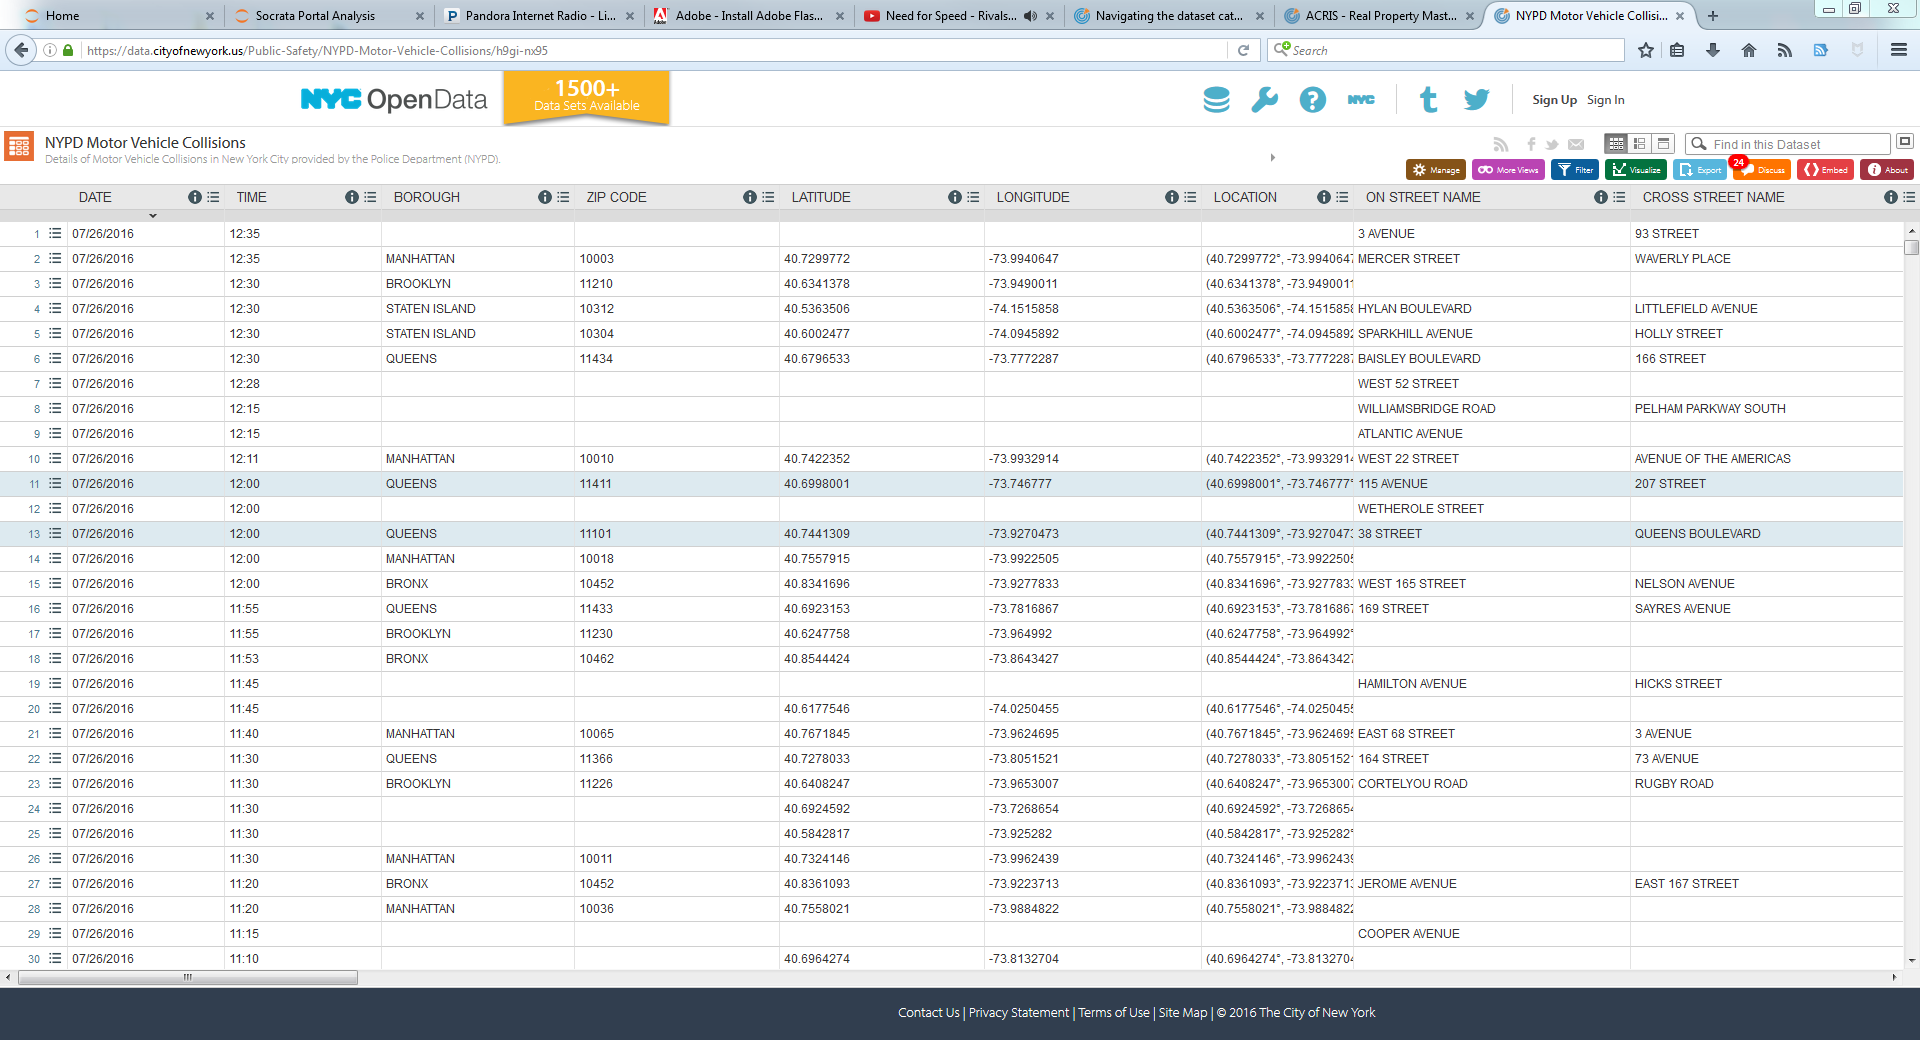

In [57]:
Image("NYPD Motor Vehicle Collision Dataset - Socrata View.png")

I refer to this as a "table" because when you hover over the little icon in the top left corner it, in a fit of inconsistency, tells you that's what it:

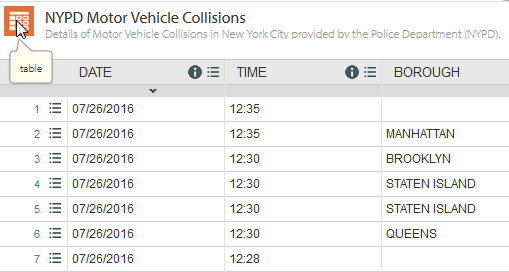

In [59]:
Image("NYPD Motor Vehicle Collision Dataset - Table Tooltip Hover.png")

**Data maps**

Maps are an endpoint type which, when visited, provides a geographic data view:

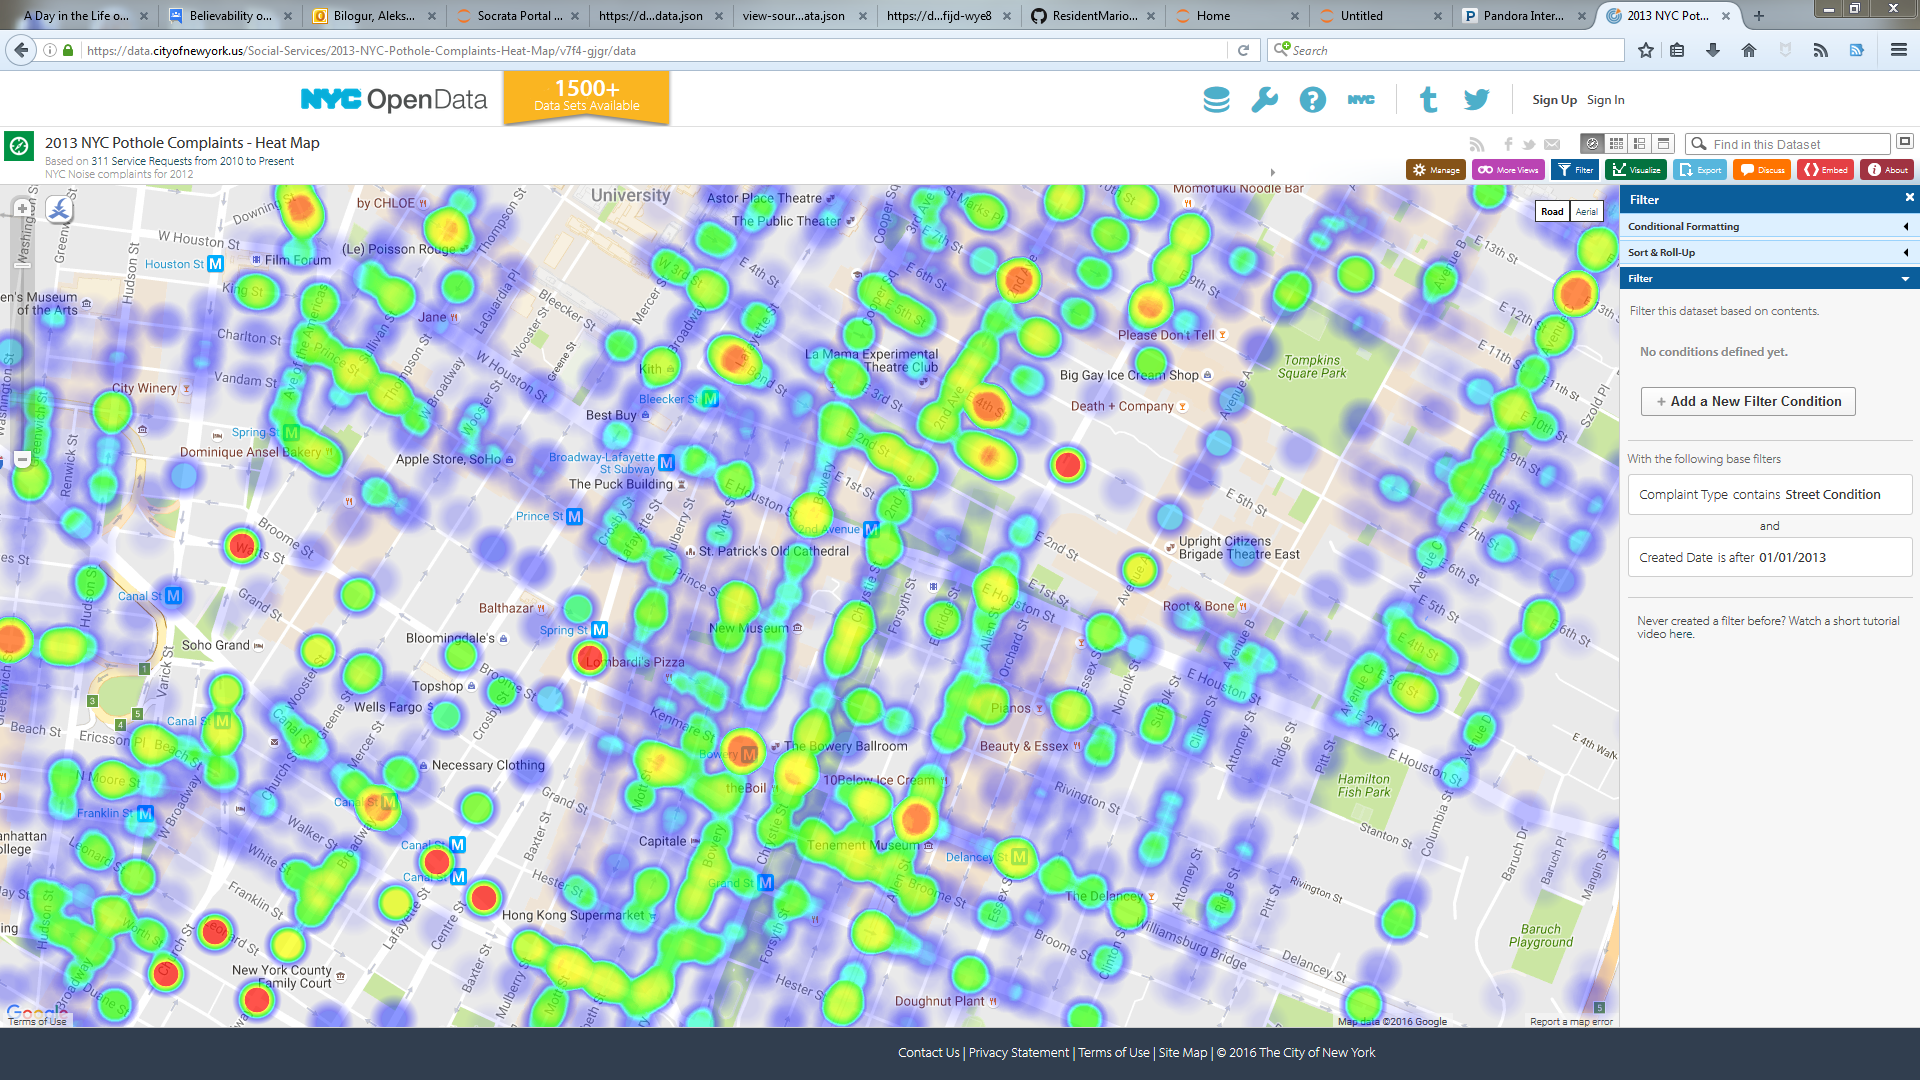

In [4]:
Image("NYC Pothole Complaints Heatmap.png")

This example is an instance of a **derived map**. You can tell that this is the case because it reports what its basis dataset is under the title:

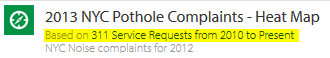

In [5]:
Image("NYC Open Data - Derived Map Highlight.png")

When considering datasets a derived map is specious because it is based on a dataset which already exists independently.

Some maps, however, come from standalone geospatial datasets. If you download them you get a dataset&mdash;the UI just pre-processed its contents for you.

These are **geospatial datasets**. They are distinguishable by the fact that they lack the derivation text:

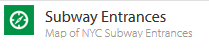

In [6]:
Image("NYC Open Data - Data Map Highlight.png")

If you download the dataset you will find one of `.SHP`, `.KMZ`, `.KML`, `.GeoJSON`, or `.JSON`.

**External datasets**

These are datasets which are provided elsewhere on the web. The Department of City Planning's [Bytes of the Big Apple](http://www1.nyc.gov/site/planning/data-maps/open-data.page), which significantly predates the open data portal, is a good example of this.

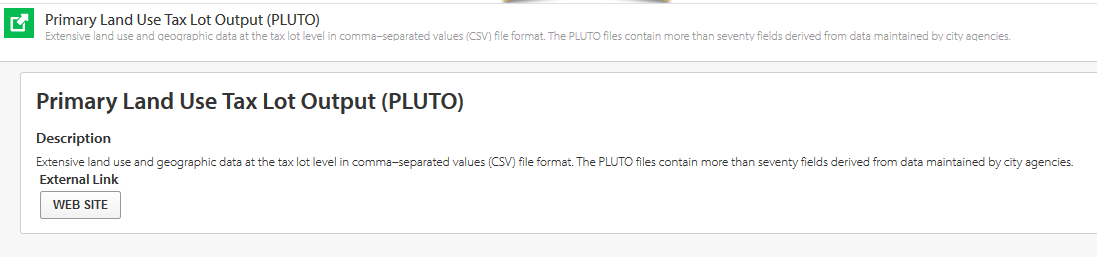

In [12]:
Image("NYC Open Data - External Dataset Endpoint Example.png")

Within Socrata these are also sometimes referred to more simply as *links*.

**Files**

When data is uploaded to Socrata in an archived non-geospatial format they are made available as simple files. A good example of this is the portal copy of the `PAD` dataset, which contains a set of zipped `.MDB` Microsoft Access database files.

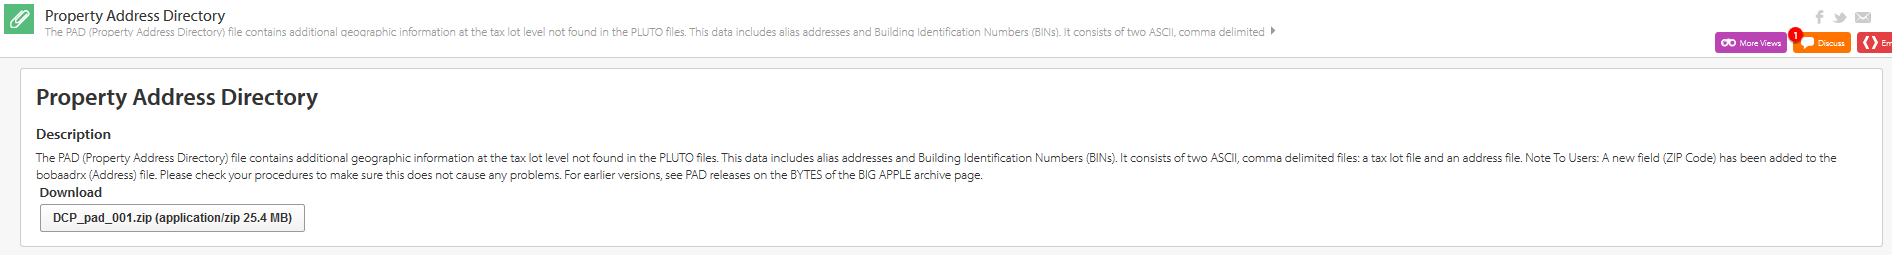

In [13]:
Image("NYC Open Data - File Endpoint Type Example.png")

Within Socrata these may also be referred to as *blobs*.

**Federated assets**

Socrata apparently allows portals to display content from other portals. I have not seen this in action. Nor do I think that there are any endpoints on the NYC domain that fall under this classification. Nevertheless, they are something to consider.

**Data Filters**

This is where the definition of a dataset gets fuzzier.

The open data portal distributes e.g. [311 Call Center inquiry data](https://data.cityofnewyork.us/view/tdd6-3ysr), but this is an astoundingly large dataset (53 million rows) that is difficult to manage as a singular blob. So it has also been broken up and redistributed in many inquiry-specific pieces (column segmentation). These are implemented as endpoints of the **filter** endpoint type.

In this case it seems probable that only the original data is classifiable as a dataset.

The ACRIS dataset, another massive multi-million row dataset, is similarly broken up (in this case, row-wise). The difference is that in this case, the original dataset isn't available (it's questionable if it even exists at all), and the filters are implemented as subselections of a "private view":

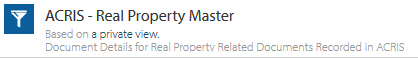

In [14]:
Image("NYC Open Data - ACRIS Filter Endpoint Example.png")

In this case it seems that each of the *individual* filters is reasonably classifiable as a dataset.

## Part II: Counts

So does "dataset" have any one reasonable definition? Perhaps not.

With all of that out of the way we can examine what the many different ways of getting a count of datasets are, are constituted of, and what the actual numbers they give are.

### Easy counts

---

#### Published Public Endpoints

The [Socrata Catalog API](http://labs.socrata.com/docs/search.html) provides a mechanism for querying for every public published endpoint. 

If you sum up the number you get you find that there are 8145 of them.

---

#### Public {Tables, Geospatial Datasets, Calendars, External Datasets, Files, Form-type Endpoints, Data Lens-type Endpoints}

These are the types of content returned by the [Raw JSON Endpoint](https://data.cityofnewyork.us/data.json).

The latter two classifications are highly questionable.

I am not sure how filters are classified for inclusion.

Data maps and *only* data maps are included in this resultset because Socrata has distinguished between the two and pre-filtered them on emission.

This is the number returned by the `RSocrata` client and the one we advertise on our portal.

As of writing this results in a count of 1529 endpoints.

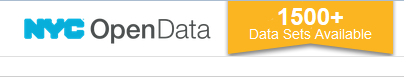

In [61]:
Image("NYPD Motor Vehicle Collision Dataset - Banner.png")

---

#### All {Tables, Geospatial Datasets, Calendars, External Datasets, Files, Form-type Endpoints, Data Lens-type Endpoints}

Every Socrata portal has a Site Analytics page which provides a range of interesting tidbits about the portal ([here's New York's](https://nycopendata.socrata.com/analytics)). One of the entries on this page is still another data set counter, with still another number attached to it:

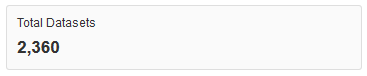

In [62]:
Image("NYC Open Data - Site Analytics Dataset Count.png")

You can count these **tables** using the Socrata Catalog API by asking for entries where the `type` field is set to `dataset`. This tells me that, as of writing, there are 1073 of them.

### Piecemeal Counts

If one is able to seperate the wheat from the chaff, so to speak, and get individual bits of the totals, then you can use them to build any definition of dataset and get its count that you damn well please.

Going in the same order again:

#### Published Public Endpoints

The [Socrata Catalog API](http://labs.socrata.com/docs/search.html) provides a mechanism for querying for every public published endpoint. 

Our number is 8145.

#### Published Public Tables

Scrape the data off of the Socrata Catalog API and select `type=dataset`.

You cannot use the JSON endpoint for this because even though it provides an `@type` field, that field is always set to `dcat:Dataset`, making it useless.

The total is 1073.

#### Published Public Geospatial Datasets

These are included in the raw JSON endpoint output, but because of the `type=dataset` glitch above they are not directly identifiable from there. But you can be clever and get them anyway: take each endpoint you get out of the raw JSON output and match it with an endpoint returned by the Socrata Catalog API, and select those endpoints in the latter which have a categorization of `type=map`. This trick returns a total of 192.

#### Published Public External Datasets

Use the Socrata Catalog API and filter on `type=href`. This returns 174.

#### Published Public Files

Use the Socrata Catalog API and filter on `type=file`. This returns 92.

#### Federated Assets

These would not be included in any domain search. AFAIK they only appear in search queries anyway when they are included, so they aren't actually interesting to include in any count. In our case it is 0.

#### Data Filters

Only hand-classification could work. The number is small enough to be inconsequential anyway.

## Part III: Operationalization

The `socrata-reducer` Python module (WIP) contains a bunch of utility scripts for generating the raw datasets and these specific counts for your portal of choice.